## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import json
import random
from collections import defaultdict
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler

import warnings

## Funciones para generar recomendaciones por cluster o para todos los clusters

In [2]:
def agregar_recomendaciones_por_cluster(df_clusters, path_json, threshold=0.01):
    recomendaciones = []
    for cluster_id in df_clusters['CLUSTER']:
        item = recomendar_producto_para_cluster(cluster_id, df_clusters, path_json, threshold)
        recomendaciones.append(item['Item'])
    df_clusters = df_clusters.copy()
    df_clusters['item_recomendado'] = recomendaciones
    return df_clusters

In [3]:
def recomendar_producto_para_cluster(cluster_id: int, df_clusters: pd.DataFrame, path_json: str, threshold: float = 0.01):
    
    with open(path_json, 'r', encoding='utf-16') as f:
        productos = json.load(f)

    cluster_row = df_clusters[df_clusters['CLUSTER'] == cluster_id].iloc[0]

    prob_vector = cluster_row.drop('CLUSTER').values

    ingredientes_relevantes = np.where(prob_vector >= threshold)[0]
    prob_relevantes = prob_vector[ingredientes_relevantes]

    productos_scores = []
    for producto in productos:
        vec = np.array(producto["ingredientes_vector"])
        ingredientes_producto = vec[ingredientes_relevantes]
        score = np.dot(ingredientes_producto, prob_relevantes)
        productos_scores.append((producto, score))

    productos_scores = [(p, s) for p, s in productos_scores if s > 0]

    if not productos_scores:
        return {"mensaje": "No hay productos compatibles con este cluster y threshold"}

    productos, scores = zip(*productos_scores)
    scores = np.array(scores)
    probabilidades = scores / scores.sum()

    producto_seleccionado = random.choices(productos, weights=probabilidades, k=1)[0]

    return producto_seleccionado

## Abrir el archivo CSV

In [4]:
ruta_csv = './customer_orders.csv'

df = pd.read_csv(ruta_csv)

print(df.head())

                            customer_id  ingredient_1  ingredient_2  \
0  00003071-f5e3-4450-8b71-691699986c4f           0.0           0.0   
1  00008406-922f-4c8e-bcbd-b281670c2308           0.0           0.0   
2  000095fa-9bbb-4ad1-bc56-c5fe9474b218           0.0           0.0   
3  000097e7-b84f-4517-a8a7-59faa7d4c7ef           0.0           0.0   
4  0000aa63-0576-4d68-8e04-3d9e9ea9861c           0.0           0.0   

   ingredient_3  ingredient_4  ingredient_5  ingredient_6  ingredient_7  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           1.0           0.0           0.0           0.0   
2           2.0           0.0           0.0           0.0           0.0   
3           2.0           4.0           0.0           0.0           0.0   
4           1.0           0.0           0.0           0.0           0.0   

   ingredient_8  ingredient_9  ...  ingredient_333  ingredient_334  \
0           0.0           0.0  ...             0.0  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532946 entries, 0 to 532945
Columns: 343 entries, customer_id to ingredient_342
dtypes: float64(342), object(1)
memory usage: 1.4+ GB


In [6]:
warnings.filterwarnings('ignore')

## Usamos el standard scaler de los datos

In [7]:
X = df.drop(columns=['customer_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Analizar los componentes PCA

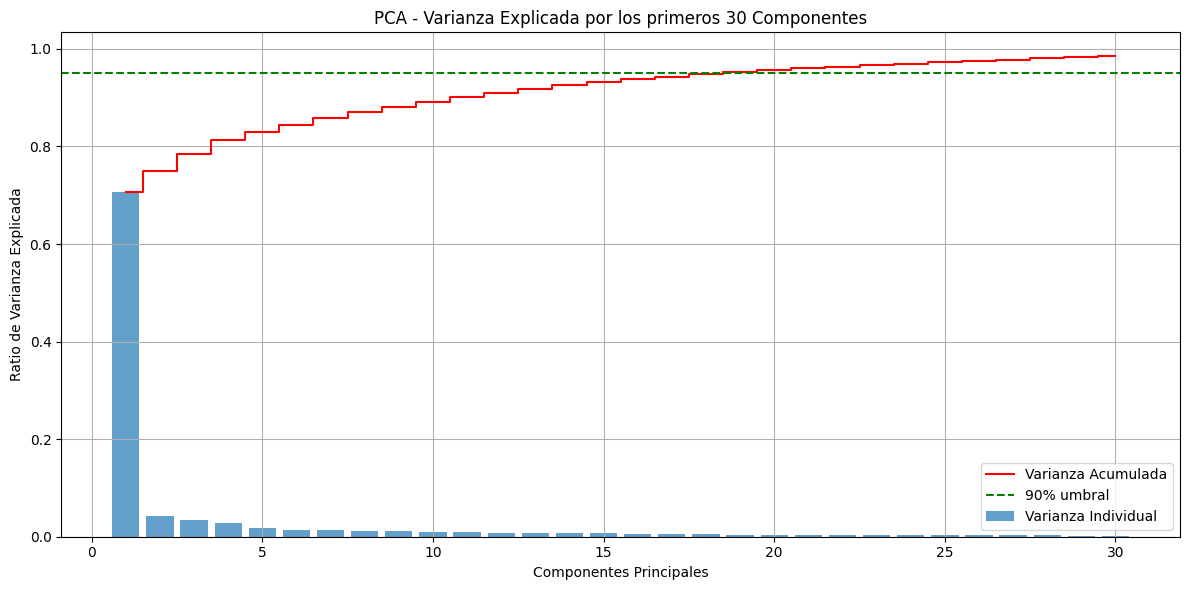

In [8]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

n_components = 30
explained_variance = pca.explained_variance_ratio_[:n_components]
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)[:n_components]

plt.figure(figsize=(12, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, label='Varianza Individual')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid', color='red', label='Varianza Acumulada')
plt.axhline(y=0.95, color='green', linestyle='--', label='90% umbral')
plt.xlabel('Componentes Principales')
plt.ylabel('Ratio de Varianza Explicada')
plt.title('PCA - Varianza Explicada por los primeros 30 Componentes')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluamos clusters con kmeans para 40-60 y con varias métricas como inertia, silhouette, etc. Luego se escoge manualmente la cantidad de clusters que tengan el mejor valor en las métricas

  File "C:\Users\JulioCesar\anaconda3\envs\Entregafinal\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\JulioCesar\anaconda3\envs\Entregafinal\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\JulioCesar\anaconda3\envs\Entregafinal\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\JulioCesar\anaconda3\envs\Entregafinal\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Mejor número de clusters: 44


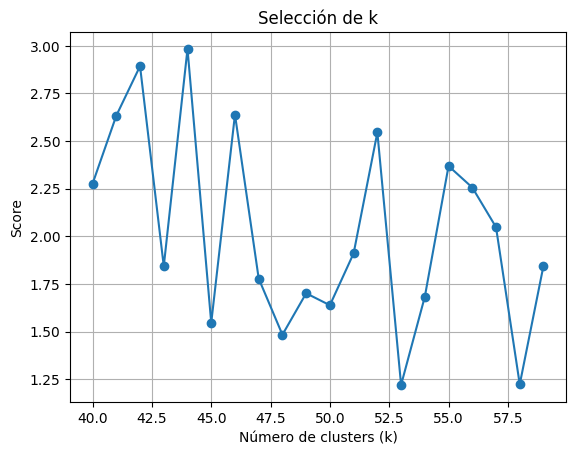

In [9]:
#Reducir dimensionalidad
pca = PCA(n_components=6, random_state=42)
X_reduced = pca.fit_transform(X_scaled)

size_samples = 20000

#Submuestrear
X_sampled = resample(X_reduced, n_samples=size_samples, random_state=42)

k_values = range(40, 60)
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels_full = kmeans.fit_predict(X_reduced)
    labels_sampled = labels_full[:size_samples]

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_sampled, labels_sampled)
    davies_bouldin = davies_bouldin_score(X_sampled, labels_sampled)
    calinski_harabasz = calinski_harabasz_score(X_sampled, labels_sampled)

    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    })

df_results = pd.DataFrame(results)

scaler = MinMaxScaler()
df_results[['inertia_norm', 'silhouette_norm', 'davies_bouldin_norm', 'calinski_harabasz_norm']] = scaler.fit_transform(
    df_results[['inertia', 'silhouette', 'davies_bouldin', 'calinski_harabasz']]
)

df_results['inertia_norm_inv'] = 1 - df_results['inertia_norm']
df_results['davies_bouldin_norm_inv'] = 1 - df_results['davies_bouldin_norm']

weights = {
    'silhouette': 1,
    'calinski_harabasz': 1,
    'inertia': 1,
    'davies_bouldin': 1
}

df_results['ensemble_score'] = (
    weights['silhouette'] * df_results['silhouette_norm'] +
    weights['calinski_harabasz'] * df_results['calinski_harabasz_norm'] +
    weights['inertia'] * df_results['inertia_norm_inv'] +
    weights['davies_bouldin'] * df_results['davies_bouldin_norm_inv']
)

best_k = df_results.loc[df_results['ensemble_score'].idxmax(), 'k']
print(f"Mejor número de clusters: {int(best_k)}")

plt.plot(df_results['k'], df_results['ensemble_score'], marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Score')
plt.title('Selección de k')
plt.grid(True)
plt.show()

## Entrenamos el kmeans con la cantidad de clusters previamente escogido

In [34]:
kmeans = KMeans(n_clusters=44, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

df['CLUSTER'] = kmeans.labels_

## Los clusters están desbalanceados

In [35]:
df['CLUSTER'].value_counts()

CLUSTER
0     525390
33      2980
35      1675
15       607
14       302
40       292
21       262
32       249
26       236
24       196
6        157
23        94
36        89
7         47
39        45
19        42
3         41
29        37
31        24
41        24
17        21
43        16
22        15
18        14
16        14
34        12
37        10
11        10
13         9
27         8
10         6
25         4
20         3
2          3
30         2
4          2
38         1
12         1
9          1
28         1
42         1
1          1
8          1
5          1
Name: count, dtype: int64

## Se suman los ingredientes en total de cada cluster

In [36]:
df_cluster_summary = df.groupby('CLUSTER').sum(numeric_only=True).reset_index()

if 'customer_id' in df_cluster_summary.columns:
    df_cluster_summary = df_cluster_summary.drop(columns=['customer_id'])

In [37]:
df_cluster_summary.head(20)

,CLUSTER,ingredient_1,ingredient_2,ingredient_3,ingredient_4,ingredient_5,ingredient_6,ingredient_7,ingredient_8,ingredient_9,...,ingredient_333,ingredient_334,ingredient_335,ingredient_336,ingredient_337,ingredient_338,ingredient_339,ingredient_340,ingredient_341,ingredient_342
0,0,0.0,12922.0,549836.0,163169.0,42300.0,978.0,872.0,0.0,978.0,...,102793.0,489121.0,0.0,75006.0,75006.0,9361.0,161293.0,6344.0,107013.0,0.0
1,1,0.0,0.0,69803.0,39100.0,24041.0,3.0,0.0,0.0,1.0,...,5076.0,52929.0,526.0,5574.0,5574.0,635.0,39697.0,406.0,28918.0,7.0
2,2,1.0,5.0,32.0,25.0,0.0,98.0,31.0,0.0,98.0,...,8.0,271.0,0.0,135.0,135.0,26.0,13.0,0.0,8.0,0.0
3,3,0.0,1582.0,504.0,171.0,21.0,2.0,0.0,0.0,2.0,...,237.0,625.0,0.0,18.0,18.0,69.0,121.0,6.0,72.0,0.0
4,4,0.0,0.0,213.0,87.0,0.0,0.0,0.0,0.0,0.0,...,34.0,13.0,0.0,4.0,4.0,0.0,4.0,0.0,4.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,13.0,...,0.0,1.0,0.0,0.0,0.0,0.0,63.0,0.0,19.0,0.0
6,6,0.0,156.0,2317.0,358.0,88.0,23.0,2.0,0.0,23.0,...,229.0,923.0,0.0,126.0,126.0,16.0,470.0,20.0,245.0,0.0
7,7,0.0,55.0,537.0,108.0,11.0,126.0,93.0,0.0,126.0,...,214.0,749.0,0.0,163.0,163.0,47.0,301.0,3.0,152.0,0.0
8,8,0.0,0.0,73.0,0.0,0.0,374.0,24.0,0.0,374.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,13.0,0.0
9,9,0.0,0.0,108.0,35.0,0.0,111.0,15.0,0.0,111.0,...,83.0,238.0,0.0,4.0,4.0,0.0,22.0,0.0,14.0,0.0


## Se normalizan los ingredientes por cluster para generar una distribución de probabilidad

In [38]:
clusters = df_cluster_summary['CLUSTER']

ingredient_values = df_cluster_summary.drop(columns=['CLUSTER'])

scaler = MinMaxScaler()
ingredient_values_normalized = scaler.fit_transform(ingredient_values.T).T

df_cluster_normalized = pd.DataFrame(ingredient_values_normalized, columns=ingredient_values.columns)
df_cluster_normalized.insert(0, 'CLUSTER', clusters)

In [39]:
df_cluster_normalized.head(20)

,CLUSTER,ingredient_1,ingredient_2,ingredient_3,ingredient_4,ingredient_5,ingredient_6,ingredient_7,ingredient_8,ingredient_9,...,ingredient_333,ingredient_334,ingredient_335,ingredient_336,ingredient_337,ingredient_338,ingredient_339,ingredient_340,ingredient_341,ingredient_342
0,0,0.000000,0.005476,0.232986,0.069141,0.017924,0.000414,0.000369,0.000000,0.000414,...,0.043557,0.207258,0.000000,0.031783,0.031783,0.003967,0.068346,0.002688,0.045345,0.000000
1,1,0.000000,0.000000,0.191648,0.107351,0.066006,0.000008,0.000000,0.000000,0.000003,...,0.013936,0.145320,0.001444,0.015304,0.015304,0.001743,0.108990,0.001115,0.079396,0.000019
2,2,0.001692,0.008460,0.054146,0.042301,0.000000,0.165821,0.052453,0.000000,0.165821,...,0.013536,0.458545,0.000000,0.228426,0.228426,0.043993,0.021997,0.000000,0.013536,0.000000
3,3,0.000000,0.648626,0.206642,0.070111,0.008610,0.000820,0.000000,0.000000,0.000820,...,0.097171,0.256253,0.000000,0.007380,0.007380,0.028290,0.049610,0.002460,0.029520,0.000000
4,4,0.000000,0.000000,0.451271,0.184322,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.072034,0.027542,0.000000,0.008475,0.008475,0.000000,0.008475,0.000000,0.008475,0.000000
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.131313,0.000000,0.000000,0.131313,...,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.636364,0.000000,0.191919,0.000000
6,6,0.000000,0.018625,0.276624,0.042741,0.010506,0.002746,0.000239,0.000000,0.002746,...,0.027340,0.110196,0.000000,0.015043,0.015043,0.001910,0.056113,0.002388,0.029250,0.000000
7,7,0.000000,0.016601,0.162089,0.032599,0.003320,0.038032,0.028071,0.000000,0.038032,...,0.064594,0.226079,0.000000,0.049200,0.049200,0.014187,0.090854,0.000906,0.045880,0.000000
8,8,0.000000,0.000000,0.154989,0.000000,0.000000,0.794055,0.050955,0.000000,0.794055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072187,0.000000,0.027601,0.000000
9,9,0.000000,0.000000,0.165138,0.053517,0.000000,0.169725,0.022936,0.000000,0.169725,...,0.126911,0.363914,0.000000,0.006116,0.006116,0.000000,0.033639,0.000000,0.021407,0.000000


## Recomendación para un cluster

In [31]:
# Recomendación para un cluster

producto_recomendado = recomendar_producto_para_cluster(0, df_cluster_normalized, 'items_procesados.json', threshold=0.01)
print(producto_recomendado['Item'] + " ingredientes: " + producto_recomendado['ingredientes'])

ITEM_N2 ingredientes: Sweet Potato, Chicken Breast, Couscous, Hummus, Green Leaf Lettuce, Cucumber, Tomatoes, Red Cabbage, Canola Oil, Lemon Juice, Salt, Garlic Powder, Cumin, Turmeric, Black Pepper, Parsley, Cinnamon


## Recomendación para todo los clusters

In [17]:
df_con_recomendaciones = agregar_recomendaciones_por_cluster(df_cluster_normalized, 'items_procesados.json', threshold=0.01)
print(df_con_recomendaciones[['CLUSTER', 'item_recomendado']])

    CLUSTER item_recomendado
0         0          ITEM_W2
1         1           ITEM_D
2         2          ITEM_M2
3         3          ITEM_K1
4         4          ITEM_X1
5         5           ITEM_I
6         6          ITEM_V3
7         7          ITEM_N2
8         8          ITEM_A1
9         9          ITEM_C4
10       10           ITEM_X
11       11          ITEM_K3
12       12          ITEM_W3
13       13          ITEM_K1
14       14          ITEM_Z1
15       15          ITEM_Q2
16       16          ITEM_V3
17       17          ITEM_W2
18       18          ITEM_G3
19       19           ITEM_F
20       20          ITEM_N1
21       21           ITEM_I
22       22           ITEM_F
23       23          ITEM_W2
24       24           ITEM_V
25       25           ITEM_M
26       26          ITEM_V3
27       27          ITEM_C3
28       28           ITEM_L
29       29          ITEM_W2
30       30          ITEM_U1
31       31          ITEM_U1
32       32          ITEM_X1
33       33   

## Intento con HDBSCAN

In [18]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels = clusterer.fit_predict(X_reduced)

In [19]:
unique_labels, counts = np.unique(labels, return_counts=True)

cluster_distribution = pd.DataFrame({
    'Cluster': unique_labels,
    'Cantidad': counts
}).sort_values(by='Cantidad', ascending=False)

print(cluster_distribution)

      Cluster  Cantidad
0          -1    148597
3640     3639     22966
2759     2758     16594
2126     2125     13659
2743     2742     12063
...       ...       ...
3311     3310        10
275       274        10
278       277        10
993       992        10
296       295        10

[4155 rows x 2 columns]


In [20]:
df_clusters = df.copy()
df_clusters['CLUSTER'] = labels

df_clusters_validos = df_clusters[df_clusters['CLUSTER'] != -1]

## Clusters mejor distribuidos pero con muchos outlayers

In [21]:
usuarios_por_cluster = df_clusters_validos['CLUSTER'].value_counts().sort_values(ascending=False)
print(usuarios_por_cluster)

CLUSTER
3639    22966
2758    16594
2125    13659
2742    12063
2129    10810
        ...  
174        10
2828       10
107        10
2869       10
4073       10
Name: count, Length: 4154, dtype: int64


In [22]:
df_cluster_summary = df_clusters_validos.groupby('CLUSTER').sum(numeric_only=True).reset_index()

if 'customer_id' in df_cluster_summary.columns:
    df_cluster_summary = df_cluster_summary.drop(columns=['customer_id'])

In [23]:
clusters = df_cluster_summary['CLUSTER']

ingredient_values = df_cluster_summary.drop(columns=['CLUSTER'])

scaler = MinMaxScaler()
ingredient_values_normalized = scaler.fit_transform(ingredient_values.T).T

df_cluster_normalized = pd.DataFrame(ingredient_values_normalized, columns=ingredient_values.columns)
df_cluster_normalized.insert(0, 'CLUSTER', clusters)

## Cada cluster con su respectivo producto recomendado

In [24]:
clusters_validos = df_clusters_validos['CLUSTER'].unique()

for cluster_id in clusters_validos:
    producto = recomendar_producto_para_cluster(cluster_id, df_cluster_normalized, 'items_procesados.json', threshold=0.01)
    print(f"Cluster {cluster_id}: Producto recomendado -> {producto['Item']}")

Cluster 2123: Producto recomendado -> ITEM_T2
Cluster 1890: Producto recomendado -> ITEM_K1
Cluster 885: Producto recomendado -> ITEM_Z3
Cluster 2750: Producto recomendado -> ITEM_Q
Cluster 614: Producto recomendado -> ITEM_Z2
Cluster 3865: Producto recomendado -> ITEM_E
Cluster 2742: Producto recomendado -> ITEM_A1
Cluster 2760: Producto recomendado -> ITEM_J1
Cluster 3731: Producto recomendado -> ITEM_E
Cluster 1063: Producto recomendado -> ITEM_U1
Cluster 3639: Producto recomendado -> ITEM_O2
Cluster 3054: Producto recomendado -> ITEM_O2
Cluster 4059: Producto recomendado -> ITEM_G3
Cluster 3363: Producto recomendado -> ITEM_D3
Cluster 415: Producto recomendado -> ITEM_Q1
Cluster 3396: Producto recomendado -> ITEM_Q
Cluster 3849: Producto recomendado -> ITEM_W3
Cluster 1095: Producto recomendado -> ITEM_F
Cluster 2743: Producto recomendado -> ITEM_U1
Cluster 236: Producto recomendado -> ITEM_N
Cluster 3095: Producto recomendado -> ITEM_X2
Cluster 939: Producto recomendado -> ITEM_O3

KeyError: 'Item'

## Cada usuario con su cluster respectivo

In [25]:
df_clusters_validos

,customer_id,ingredient_1,ingredient_2,ingredient_3,ingredient_4,ingredient_5,ingredient_6,ingredient_7,ingredient_8,ingredient_9,...,ingredient_334,ingredient_335,ingredient_336,ingredient_337,ingredient_338,ingredient_339,ingredient_340,ingredient_341,ingredient_342,CLUSTER
0,00003071-f5e3-4450-8b71-691699986c4f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2123
1,00008406-922f-4c8e-bcbd-b281670c2308,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1890
4,0000aa63-0576-4d68-8e04-3d9e9ea9861c,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,885
5,0000b06f-82aa-44e0-9dd4-218ebeff8cfd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2750
6,0000c481-e2b2-4b17-ae40-5d87b531c717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,9.0,0.0,7.0,0.0,614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532934,ffff2efe-ef2d-46b2-acbd-000e2a59614b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3740
532937,ffff8739-c827-49a5-b116-1615190b8336,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2536
532939,ffff8e67-9ecf-453d-b34a-28a7e4e43d2b,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2742
532942,ffffab2c-caba-4ae6-a5a0-38ba09e780c8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1927
